#### **Named Entity Recognition using LSTM**

The NLP task [Named Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) (NER) is to classify named entity's within a corpus into predefined categories.

We explore the use of a [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) architecture to perform NER. The dataset used is the MIT-Restaurants dataset. The tagging of the dataset is in the [IOB2](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) format.

Note: Framework based off https://github.com/lingo-mit/6864-hw2/blob/master/6864_hw2.ipynb

Note: For a gentler introduction to the LSTM architecture see [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

#### **Setup**

Read in the dataset

In [1]:
import numpy as np

import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import util


device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda" # use a gpu!


train_data = util.read_file_txt("../data/mit_restaurants-train.dat", type = "word")
train_tags = util.read_file_txt("../data/mit_restaurants-train.tag", type = "word")

test_data = util.read_file_txt("../data/mit_restaurants-test.dat", type = "word")
test_tags = util.read_file_txt("../data/mit_restaurants-test.tag", type = "word")

print('number of training samples:', len(train_data))
print('number of testing samples:',  len(test_data))
# print('average sentence length in training data', (np.mean([len(sent) for sent in train_data])))
print()

print('the first few sentences are:', train_data[0:3])
print('and their cp\'ding named entity sequences are: ', str(train_tags[0:3]))
print()

number of training samples: 7660
number of testing samples: 1521

the first few sentences are: [['2', 'start', 'restaurants', 'with', 'inside', 'dining'], ['34'], ['5', 'star', 'resturants', 'in', 'my', 'town']]
and their cp'ding named entity sequences are:  [['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity'], ['O'], ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location']]



#### **Data Preprocessing**

In [2]:
# helper functions and more data preprocessing before we move on to implementing our models.

# from train data, collect all unique word types as a set and add 'UNK' to it (unseen words in test data will be turned into 'UNK')
vocab_set = list(set([word for sent in train_data for word in sent])) + ['UNK']
num_vocabs = len(vocab_set)
print("number of word types (including 'UNK'):", num_vocabs)
print("the first couple and last couple of words in the vocabulary set:", vocab_set[0:2] +  vocab_set[-2:])

vocab2id = {v : i for i, v in enumerate(vocab_set)}

#  collect all tag (class) types and assign an unique id to each of them. (here there won't be a unseen tag type in test data)
tag_set = list(set([tag for tag_seq in train_tags for tag in tag_seq]))
num_tags = len(tag_set)
print("number of tag types:", num_tags)
print()

# assign each tag type a unique id, also create the inverse dict of tag2id (required during evaluation)
tag2id = {t : i for i, t in enumerate(tag_set)} 
id2tag = {i : t for t, i in tag2id.items()}

# apply one-hot encoding to data.
train_data_oh_list = [util.one_hot_encoding(sent, vocab2id, vocab_set) for sent in train_data]
# print("oh data[0] - len:", len(train_data_oh_list[0]), "shape:", train_data_oh_list[0].shape)

# transform tag names into ids
train_tags_id_list = [util.encoding_idx(tag_seq, tag2id) for tag_seq in train_tags]
# print("list len, tag data:", len(train_tags_id_list))

# train_data_oh_list should now be a list of 2d-tensors, each has shape (sent_len, num_vocabs)
# Note that to utilize the `shape` attribute, each element in the list should already be a torch tensor.
print("first sentence has shape: %s" % str(train_data_oh_list[0].shape))
print("fifth sentence has shape: %s" % str(train_data_oh_list[4].shape))

# train_tags_id_list is a list of 1d-tensors, each that has shape (sent_len,)
print("first tag sequence has shape: %s" % train_tags_id_list[0].shape)
print("fifth tag sequence has shape: %s" % train_tags_id_list[4].shape)
print()


# Apply same conversion to test dataset.
test_data_oh_list = [util.one_hot_encoding(sent, vocab2id, vocab_set) for sent in test_data]
test_tags_id_list = [util.encoding_idx(tag_seq, tag2id) for tag_seq in test_tags]
# print("list len, oh test:", len(test_data_oh_list))
# print("list len, tag test:", len(test_tags_id_list))
# print("first sentence has shape: %s" % str(test_data_oh_list[0].shape))
# print("fifth sentence has shape: %s" % str(test_data_oh_list[4].shape))


number of word types (including 'UNK'): 3805
the first couple and last couple of words in the vocabulary set: ['blocks', 'usual', 'shack', 'UNK']
number of tag types: 17

first sentence has shape: torch.Size([6, 3805])
fifth sentence has shape: torch.Size([12, 3805])
first tag sequence has shape: 6
fifth tag sequence has shape: 12



#### **LSTM**

We implement a vanilla LSTM from scratch, then train it and evaluate its performance on the NER task.



##### **LSTM architecture**

In [0]:
class LSTM_NER(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.sz_ip = input_size
    self.sz_hi = hidden_size
    self.sz_op = output_size        

    self.gate_ip = nn.Linear(self.sz_ip + self.sz_hi, self.sz_hi)   # input gate
    self.gate_fg = nn.Linear(self.sz_ip + self.sz_hi, self.sz_hi)   # forget gate
    self.gate_op = nn.Linear(self.sz_ip + self.sz_hi, self.sz_hi)   # output gate    
    self.cell_cand = nn.Linear(self.sz_ip + self.sz_hi, self.sz_hi) # candidate cell
    self.output = nn.Linear(self.sz_hi, self.sz_op)
            

  def forward(self, input, hidden, memory):
    """
    The `forward` function just performs one step of update and output logits before softmax.

    `input` is a 2d-tensor of shape (1, input_size);
    `hidden` and `memory` are both 2d-tensors of shape (1, hidden_size), representing the hidden and memory states of the previous time step.
    """

    combined = torch.cat( (input, hidden), dim = 1)
    # print("input, combined, memory:", input.shape, combined.shape, memory.shape)
      
    memory = (torch.sigmoid(self.gate_fg(combined)) * torch.tanh(memory)) + (torch.sigmoid(self.gate_ip(combined)) * torch.tanh(self.cell_cand(combined)))
    # print("memory:", memory.shape)
    
    hidden = torch.sigmoid(self.gate_op(combined)) * torch.tanh(memory)
    # print("output:", output.shape)
    
    output = self.output(hidden)

    return output, hidden, memory


  def init_state(self):
    """     # initialize hidden and memory states."""
    return (torch.zeros(1, self.sz_hi).to(device), torch.zeros(1, self.sz_hi).to(device))

##### **Training**

The function $train\_one\_sample$, takes a (sentence tensor, tag tensor) pair as input and does one step of the gradient update.

The input size is set to the vocbulary size of the dataset, the size of the hidden state is set to $128$ and the output size is set to the number of tags in the dataset.

In [30]:
learning_rate = 1e-3
hidden_size = 33


model = LSTM_NER(input_size = num_vocabs, hidden_size = hidden_size, output_size = num_tags).to(device)
print("The model has {} parameters".format(sum(p.numel() for p in model.parameters())))
 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


"""
Run through a sentence, generate output, compute loss, and perform one gradient update
Sentence and tag are represented as a 2d-tensor `sent_tensor` and a 1d-tensor `tag_tensor`, respectively.
"""
def train_one_sample(model, sent_tensor, tag_tensor):
  hidden, memory = model.init_state()     # initialize hidden state
  loss = torch.zeros(1, dtype = torch.float).to(device)

  # print(sent_tensor.device, tag_tensor.device, hidden.device, outputs.device, (torch.cuda.LongTensor([tag_tensor[0]]).to(device)).device)

  for idx in range(sent_tensor.shape[0]):
    outputs, hidden, memory = model(sent_tensor[idx].reshape(1, sent_tensor.shape[1]), hidden, memory)
    # print(outputs.shape)
    loss = loss + criterion(outputs, torch.LongTensor([tag_tensor[idx]]).to(device))
      
  loss = loss / len(tag_tensor)   # average the loss over all tags in the sentance

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return outputs, loss.item()


# main training loop for the lstm
num_epochs = 4
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []

b_calc_grad_norm = True # set to true if we want to analyze how the gradient changes over training

if b_calc_grad_norm:
  current_grad_norm = 0
  all_grad_norms = []


start = time.time()

model.train()
 
for idx_epoch in range(num_epochs):
  for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
    sent_tensor = sent_tensor.to(device)
    tag_tensor = tag_tensor.to(device)

    output, loss = train_one_sample(model, sent_tensor, tag_tensor)
    current_loss += loss

    if b_calc_grad_norm:
      grad = torch.FloatTensor( (1, 1)).to(device)
      
      for param in model.parameters():
        grad = torch.cat( (grad, torch.reshape(param.grad, (-1, ))))
      
      current_grad_norm += grad.to("cpu") # torch.norm(grad.to("cpu"), 2)

    if iter_count % print_every == 0:
      print("epoch: {}, iteration: {}, time: {}, loss: {:0.4f}".format(idx_epoch, iter_count, util.time_since(start), loss))

    # add current loss avg to list of losses
    if iter_count % plot_every == 0 and iter_count > 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0
      
      if b_calc_grad_norm: 
        all_grad_norms.append(torch.norm(current_grad_norm) / plot_every)
        current_grad_norm = 0

    iter_count += 1

The model has 507326 parameters
epoch: 0, iteration: 0, time: 0m 0s, loss: 2.8291
epoch: 0, iteration: 1000, time: 0m 24s, loss: 3.1580
epoch: 0, iteration: 2000, time: 0m 47s, loss: 0.9430
epoch: 0, iteration: 3000, time: 1m 13s, loss: 2.3500
epoch: 0, iteration: 4000, time: 1m 38s, loss: 1.4064
epoch: 0, iteration: 5000, time: 2m 2s, loss: 0.1647
epoch: 0, iteration: 6000, time: 2m 26s, loss: 0.5923
epoch: 0, iteration: 7000, time: 2m 49s, loss: 0.8795
epoch: 1, iteration: 8000, time: 3m 12s, loss: 0.3530
epoch: 1, iteration: 9000, time: 3m 38s, loss: 0.9901
epoch: 1, iteration: 10000, time: 4m 1s, loss: 0.3086
epoch: 1, iteration: 11000, time: 4m 27s, loss: 0.5451
epoch: 1, iteration: 12000, time: 4m 53s, loss: 0.0344
epoch: 1, iteration: 13000, time: 5m 16s, loss: 0.0572
epoch: 1, iteration: 14000, time: 5m 41s, loss: 0.0159
epoch: 1, iteration: 15000, time: 6m 4s, loss: 1.2796
epoch: 2, iteration: 16000, time: 6m 29s, loss: 0.2070
epoch: 2, iteration: 17000, time: 6m 54s, loss: 0.

##### **Evaluation**

We plot the learning curve. We also evaluate the model on the test data.

###### **Learning Curve**

We plot the learning curve.

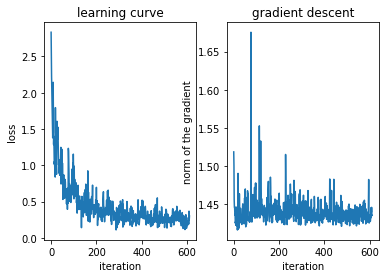

In [31]:
# plot the learning curve. The x-axis is the training iterations and the y-axis is the training loss. The loss should be going down.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

x_axis_pts = np.array([idx for idx, _ in enumerate(all_losses)])

if b_calc_grad_norm:
  fig, (ax_1, ax_2) = plt.subplots(1, 2)
  
  ax_1.plot(x_axis_pts, all_losses)
  ax_1.set_xlabel("iteration")
  ax_1.set_ylabel("loss")
  ax_1.set_title("learning curve");

  ax_2.plot(x_axis_pts, all_grad_norms)
  ax_2.set_xlabel("iteration")
  ax_2.set_ylabel("norm of the gradient")
  ax_2.set_title("gradient descent");

else:
  fig, ax = plt.subplots()
  ax.plot(x_axis_pts, all_losses)
  ax.set_xlabel("iteration")
  ax.set_ylabel("loss")
  ax.set_title("learning curve");

###### **Inference**

We use the trained model to run inference on the test dataset and compute the [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall) and [f1 score](https://en.wikipedia.org/wiki/F1_score)

In [32]:
# Make prediction for one sentence.
def predict(model, sent_tensor):
  hidden, memory = model.init_state()

  predicted_tag_id = []

  for idx in range(sent_tensor.shape[0]):
    outputs, hidden, memory = model(sent_tensor[idx].reshape(1, sent_tensor.shape[1]), hidden, memory)
    predicted_tag_id.append(np.argmax(outputs.detach().cpu().numpy()))

  return predicted_tag_id
 
 
model.eval()
predicted_tags = []
 
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = predict(model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id])
  
   
# precision, recall, and f1 score

# Example: true_tag_list/predicted_tag_list:
#   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
#    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
precision, recall, f1_score = util.evaluate_result(test_tags, predicted_tags)
print("precision: {:0.4f}, recall: {:0.4f}, f1 score: {:0.4f}".format(precision, recall, f1_score))

precision: 0.7776, recall: 0.7805, f1 score: 0.7730
